The point of this notebook is to illustrate the fundamental use of the orinoco software library. We will create a number of products including:

1. A distance raster with the signed distance function $\varphi$ for inspection.
2. A segments raster used to create the Region Adjacency Graph (RAG) graph.
3. A directed network in NetworkX format that is serialized as a pickle file.
4. Said network saved as (a) Nodes (points) and (b) edges (lines) for viewing in GIS viewing software (e.g. QGIS)
5. A width geometry whose length is the measured width and whose orientation indicates the line which the width is measured.

*Note: we save all our vector files as `.geojson` because it preserves the column names (shapefiles have 10 character limit). However, older versions of QGIS do not support geojson easily (we are using 3.4.8). If you are not able to update QGIS, then simply remove the driver keyword in the geopandas GeoDataFrame command `df.to_file(<path_to_vector_file>, driver='GeoJSON')`, as the default is a shapefile.*

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import networkx as nx
from orinoco import (get_distance_along_channel_using_fmm,
                     get_distance_segments,
                     get_undirected_channel_network,
                     direct_channel_network_using_distance,
                     export_edges_to_geodataframe,
                     export_nodes_to_geodataframe,
                     get_map_centroid_from_binary_mask,
                     apply_func_to_superpixels,
                     get_array_from_features,
                     add_flow_attributes,
                     change_tuples_to_vector,
                     get_geopandas_features_from_array,
                     get_RAG_neighbors,
                     get_segment_df,
                     get_geo_width_df,
                     update_graph_with_widths
                     )
from skimage.color import label2rgb
import random
from shapely.geometry import Point, LineString, MultiLineString, GeometryCollection
from shapely.ops import unary_union
import geopandas as gpd
import scipy.ndimage as nd
from scipy.ndimage import find_objects
from rasterio import features
from tqdm import tqdm
from rasterio.transform import rowcol


# Initialize Paths for Data Input And Output

We are going to create directories for our out put products to be saved to. Again there are two options:

1. `stamen_terrain_12`
2. `google_16`

*Warning*: `google_16` has a high spatial resolution (2 meters) and will take significantly more time to process (and display using `imshow`) at each stage. You may want to comment the `imshow` commands if processing google.

Change the `map_name` below to toggle between these options.

In [2]:
map_name = 'stamen_terrain_12'  # options are `stamen_terrain_12` or `google_16`
data_path = Path(f'data/{map_name}')

In [3]:
product_dir = Path('products')
products_for_map_dir = product_dir/map_name
products_for_map_dir.exists()

True

# Open the Input Products to Generate a Channel Network

We need:

1. Water mask
2. Ocean/Initialization Mask

In the previous notebook, we obtained these products from open tile servers. We assume that these products:

+ Have the same GIS metadata (same rasterio profile)
+ Are in UTM, that is their resolution is measured in meters

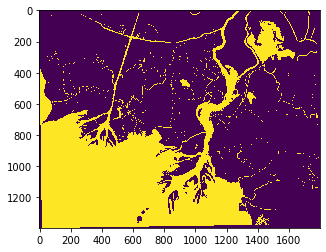

In [4]:
with rasterio.open(products_for_map_dir/'water_mask.tif') as ds:
    water_mask = ds.read(1)
    transform = ds.transform
plt.imshow(water_mask, interpolation='none')

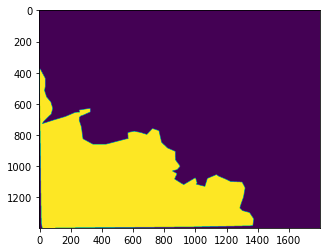

In [5]:
with rasterio.open(products_for_map_dir/'ocean_mask.tif') as ds:
    ocean_mask = ds.read(1)
    profile = ds.profile
plt.imshow(ocean_mask)

We are going to get the resolution distance in the upper right corner (origin). Of course, this is not valid through the entire raster. The fast-marching method will use this `dx, dy` to approximate distance to our initialization mask (namely the ocean). We will update this distance at the end.

In [6]:
dx, dy = transform.a, -transform.e
dx, dy

(25.0, 25.0)

# Obtaining the Distance Function

We obtain using [`scikit-fmm`](https://pythonhosted.org/scikit-fmm/) the distance function ($\varphi$).

In [7]:
if map_name == 'stamen_terrain_12':
    area_threshold = .025
else:
    area_threshold = 0

dist = get_distance_along_channel_using_fmm(water_mask,
                                            ocean_mask,
                                            dx=dx,
                                            dy=dy,
                                            # removes areas with less than percentage of total size
                                            area_threshold=area_threshold,
                                            # Applys a 1 pixel buffer for distance computation
                                            # for artifical 8-connectivity.
                                            # See: https://github.com/scikit-fmm/scikit-fmm/issues/32
                                            # Removes buffer after computation complete.
                                            apply_pixel_buffer_for_distance_comp = True
                                            )

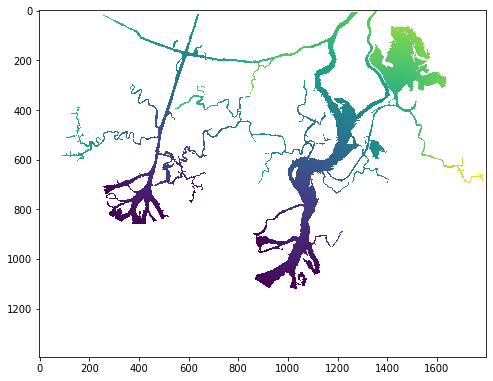

In [8]:
plt.figure(figsize=(8, 8))
plt.imshow(dist, interpolation='none')

We write the distance function to a raster. Note our assumption that our water mask is in UTM means this $\varphi$ function to is measured in meters.

In [9]:
p = profile.copy()
p['dtype'] = 'float32'
with rasterio.open(products_for_map_dir/'distance.tif', 'w', **p) as ds:
    ds.write(dist.astype(np.float32), 1)

# Segmentation of the Channel for the Region Adjacency Graph (RAG)

The labels are defined according to the formula $l(x):= \lfloor \varphi(x) / D \rfloor$, where $x \in$ channel mask and $D$ is some threshold. Below, the `pixel_step * res`$= D$. Further, we ensure that each label is contiguous (i.e. connected in the sense of [pixel connectivity](https://en.wikipedia.org/wiki/Pixel_connectivity)). We will use the related Region Adjacency Graph as defined [here](https://ieeexplore.ieee.org/document/841950) associated with these segments.

In [10]:
pixel_step = 5

segments, interface_adj_segments = get_distance_segments(dist,
                                                         pixel_step,
                                                         dx=dx,
                                                         dy=dy)

rag neighbors: 100%|██████████| 141/141 [00:00<00:00, 12322.82it/s]


The above provides us with

+ segments - an m x n matrix in which each pixel is assigned a label.
+ interface_adj_segments

We assume that label 0 is background for orinoco (as does `scipy.ndimage` e.g. [`label_comprehension`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.measurements.labeled_comprehension.html)).

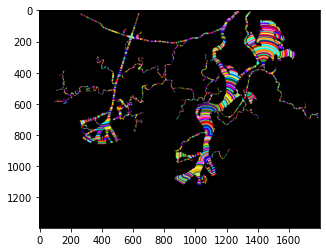

In [11]:
segments_rgb = label2rgb(segments, bg_label=0)
plt.imshow(segments_rgb)

In [12]:
p = profile.copy()
p['dtype'] = 'int32'
with rasterio.open(products_for_map_dir/'segments.tif', 'w', **p) as ds:
    ds.write(segments.astype(np.int32), 1)
    
p = profile.copy()
p['dtype'] = 'float32'
p['count'] = 3

with rasterio.open(products_for_map_dir/'segments_rgb.tif', 'w', **p) as ds:
    ds.write(segments_rgb.transpose([2, 0, 1]).astype(np.float32))

## The Interface Segments

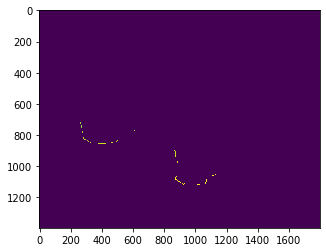

In [13]:
segment_interface_slice = np.isin(segments, interface_adj_segments)
segments_along_interface = segments.copy()
segments_along_interface[~segment_interface_slice] = 0
plt.imshow(segments_along_interface, interpolation='none')

In [14]:
p = profile.copy()
p['dtype'] = 'int32'
with rasterio.open(products_for_map_dir/'segments_along_interface.tif', 'w', **p) as ds:
    ds.write(segments_along_interface.astype(np.int32), 1)

# Making an Undirected Network using the RAG

We will make our first graph using the [RAG](https://ieeexplore.ieee.org/document/841950) from the segments. We implement this extraction of our RAG but a visual example of such a network can be found [here](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_rag_draw.html#sphx-glr-auto-examples-segmentation-plot-rag-draw-py). The `connectivity` parameters below and hereafter refer to how neighbors are determined using the so-called [pixel-connectivity](https://en.wikipedia.org/wiki/Pixel_connectivity), i.e. do we allow adjacency to determine through diagonal pixels (if yes, this is 8-connectivity; if not, this is 4-connectivity).

The graph itself will be composed of:

- Nodes, the centroids of the segment
- Edges, the neighbors of which are determined by the RAG.

In [40]:
chanG_undirected = get_undirected_channel_network(segments, 
                                                  dist, 
                                                  profile, 
                                                  interface_adj_segments,
                                                  connectivity=8)

# We have exported our data to a NetworkX graph 
type(chanG_undirected)

adding edges: 100%|██████████| 2692/2692 [00:00<00:00, 180535.74it/s]


networkx.classes.graph.Graph

Below are the node attributes that have been created for each node in the graph. We note that the node key is its `(x, y)` position in our UTM grid! The label refers to the segment label.

In [17]:
node_data =dict(chanG_undirected.nodes(data=True))
random.choice(list(node_data.items()))

((657420.8333333334, 3276762.5),
 {'label': 704,
  'meters_to_interface': 24745.8203125,
  'x': 657420.8333333334,
  'y': 3276762.5,
  'interface_adj': False})

Similarly, we have edge data. At this point we only have `weight` $=$ `lengt_m`, which is the straight line distance between the two nodes that determine the edges on our UTM grid.

In [18]:
edge_data =(chanG_undirected.edges(data=True))
edge_data = {(e[0], e[1]): e[2] for e in edge_data}
random.choice(list(edge_data.items()))

(((678222.5122850123, 3279132.708845209),
  (678086.9826435247, 3279117.1562082777)),
 {'length_m': 136.41909044294462, 'weight': 136.41909044294462})

We can use networkX to visualize our node. We specify its position precisely using its `(x, y)` node identifier.

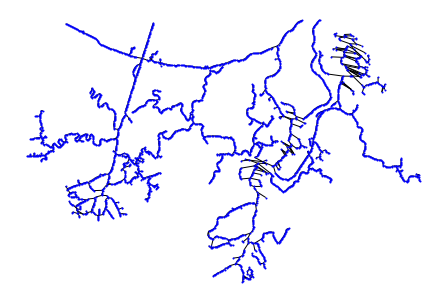

In [19]:
pos = {node: node for node in node_data.keys()}
nx.draw(chanG_undirected, 
        pos=pos, 
        node_size=1, 
        node_color='blue')
plt.show()

# Directing our Channel Network

Using the distance to the interface, we partition are edges between degree 1 nodes, junctions, and those connected to the interface. We then direct the nodes towards endpoints that are closer to the ocean within each edge group determined by this partition. We also "prune" edge groups that are small.

In [20]:
chanG = direct_channel_network_using_distance(chanG_undirected, 
                                              # The keywords below are how the pruning occurs
                                              # Specifies pruning will be done
                                              remove_danlging_segments=True, 
                                              # Do not prune nodes within 1 km of interface
                                              meters_to_interface_filter_buffer=1_000,     
                                              # Remove edge groups with an degree 1 endpoint and size <=3
                                              segment_threshold=3,
                                              # How many times to do this pruning
                                              dangling_iterations=1
                                              )

Let's visualize it once more now with arrows.

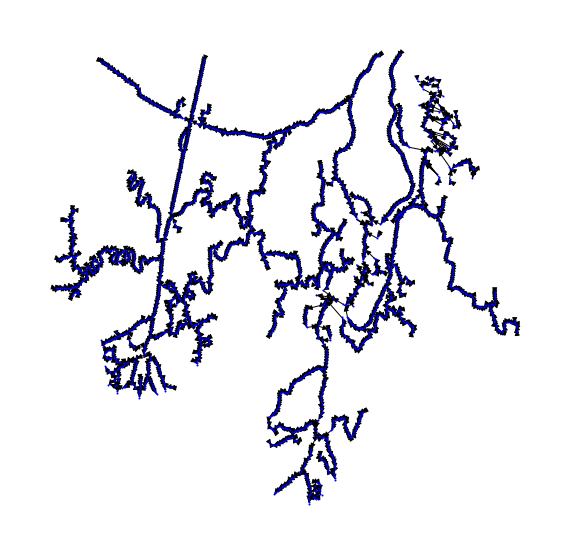

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(chanG, 
        pos=pos, 
        node_size=1,
        arrows=True,
        arrowsize=10,
        ax=ax,
        node_color='blue')
plt.show()

We now are ready to export our network to a geopandas Dataframe for easy GIS integration.

In [42]:
df_edges = export_edges_to_geodataframe(chanG, profile['crs'])
df_edges.head()

,length_m,weight,segment_id,edges_in_segment,cc_id,width_m,geometry
0,348.216785,348.216785,0,1,0,381.922018,"LINESTRING (647578.963 3267157.622, 647362.179..."
1,187.554523,187.554523,1,1,0,608.352651,"LINESTRING (647578.963 3267157.622, 647500.000..."
2,137.491329,137.491329,2,11,0,488.743488,"LINESTRING (648861.111 3267644.167, 648764.759..."
3,124.356158,124.356158,2,11,0,422.658949,"LINESTRING (648764.759 3267546.084, 648641.463..."
4,129.901269,129.901269,2,11,0,435.468666,"LINESTRING (648641.463 3267529.878, 648512.059..."


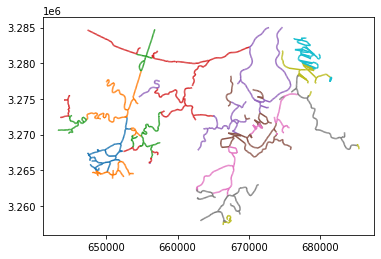

In [23]:
df_edges.plot(column='segment_id', categorical=True)

At the end of this notebook, we will see how to easily export these to GIS formats for viewing in your favorite GIS viewer e.g. QGIS.

# Drawing the Sink of Our Directed Network (Optional)

What follows here is not entirely necessary for the final products. It is more to illustrate how to manipulate the graph structure specified by `NetworkX` and to visualize the interface from the fast-marching method as a sink in our network. Specifically, we are going to add a node in the middle of the ocean where are signed distance function is 0.

In [24]:
ocean_centroid = get_map_centroid_from_binary_mask(ocean_mask, profile)
ocean_centroid

(654489.7191008729, 3257678.169107866)

/Users/cmarshak/anaconda3/envs/orinoco_env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


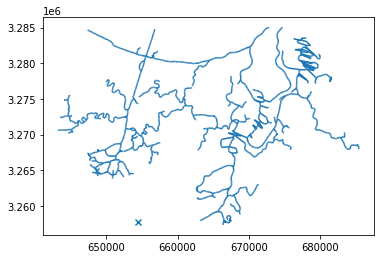

In [25]:
fig, ax = plt.subplots()
df_ocean_centroid = gpd.GeoDataFrame(geometry=[Point(ocean_centroid)],
                                     crs={'init':'epsg:4326'})
df_edges.plot(ax=ax)
df_ocean_centroid.plot(ax=ax, marker='x')

Having the channel network in networkX, we can make this connection explicit. We do this to show how to manipulate the NetworkX graph structure. We will add the ocean centroid to a copy of our graph (with weights 0) connecting the ocean centroid to those nodes that are adjacent to the interface.

In [26]:
connected_to_interface = [node for node in chanG.nodes() if (chanG.nodes[node]['interface_adj'])]
chanG_sink = chanG.copy()

edge_data_to_interface = {(node, ocean_centroid): {'weight': 0,
                                                   'meters_to_interface': 0} for node in connected_to_interface}

chanG_sink.add_edges_from(edge_data_to_interface.keys())

nx.set_edge_attributes(chanG_sink, edge_data_to_interface)

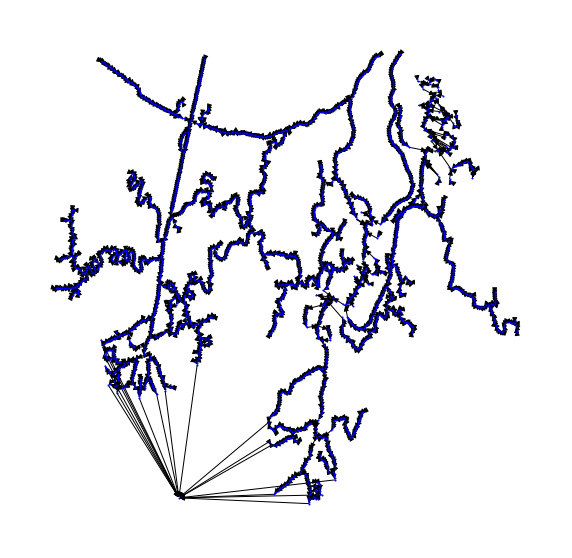

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
pos[ocean_centroid] = ocean_centroid

nx.draw(chanG_sink, 
        pos=pos, 
        node_size=1,
        arrows=True,
        arrowsize=10,
        ax=ax,
        node_color='blue')
plt.show()

# Updating Our Network with Channel Width

We are going to illustrate how we upate our network with channel width data using our software. Our approach is as follows.

1. If $\nabla \varphi$ (the gradient of our distance function) exists at the node (the centroid of the associated segment), we measure the width as the intersection within this segment and a k-hop-neighborhood.
2. If the gradient in 1. is undefined, we use the average direction of edges connected to the said node and measure width perpendicular to this direction. See our paper for more precise details.


## Obtaining Orientation of Width Measurement

We obtain the orientation of lines that we will intersect in subsequent parts for determining channel width. Our functions labeled using "flow" because we are effectively measuring the "artificial flow direction" according to $\nabla \varphi$.

In [43]:
chanG = add_flow_attributes(chanG, dist, profile['transform'])

flow vector computation using network: 100%|██████████| 2563/2563 [00:00<00:00, 7151.45it/s]


Observe the new attributes in the node data:

In [44]:
node_data =dict(chanG.nodes(data=True))
random.choice(list(node_data.items()))

((659992.3076923077, 3275089.423076923),
 {'label': 970,
  'meters_to_interface': 20721.09467443255,
  'x': 659992.3076923077,
  'y': 3275089.423076923,
  'interface_adj': False,
  'graph_degree': 2,
  'cc_id': 0,
  'flow_vector_perp_grad': (-0.7338874, -0.67927116),
  'flow_vector_network': (-0.6199036311349422, 0.7846779518412081),
  'flow_vector_perp_network': (-0.7846779518412081, -0.6199036311349422),
  'flow_vector_perp': (-0.7338874, -0.67927116),
  'width_m': 136.2607164934573})

## Obtain Segment Geometries

Let's obtain the segment labels as geometries and their relevant metadata. This will allow us to perform geometric intersection via `Shapely`.

In [45]:
df_segments = get_segment_df(segments, chanG, profile)
df_segments.head()

,label,geometry,perimeter,node,flow_vector_perp
0,1,"POLYGON ((674525.000 3285075.000, 674525.000 3...",900.0,"(674618.75, 3284987.5)","(-0.852837, 0.52217716)"
1,2,"POLYGON ((674625.000 3285075.000, 674625.000 3...",500.0,"(674701.6666666666, 3285051.6666666665)","(0.6120128715012784, -0.7908478014869611)"
2,3,"POLYGON ((672500.000 3285050.000, 672500.000 3...",1400.0,"(672575.6666666666, 3284913.6666666665)","(-0.7214943, 0.6924204)"
3,4,"POLYGON ((672550.000 3285050.000, 672550.000 3...",1000.0,"(672700.0, 3284964.150943396)","(-0.715463, 0.69865066)"
4,5,"POLYGON ((672725.000 3285050.000, 672725.000 3...",600.0,"(672816.304347826, 3285015.217391304)","(-0.69900024, 0.7151214)"


We will save these polygons as a shapefile for posterity.

In [31]:
df_segments_out = change_tuples_to_vector(df_segments)
df_segments_out.to_file(products_for_map_dir/'segments.geojson', 
                        driver='GeoJSON')

Now, we actually obtain the width geometries (their orientations and length) in a geopandas dataframe. This is a very expensive computation, even for small networks.

We intersect the candidate geometries in a small neighborhood of a node. The size of this neighborhood is determined according to `radius` below.

We define k-hop neighborhood of $b$ $N_k(v) = \{s \; | \; s$ is connected to $v$ by no more than $k$ edges in G$\}$, where $G$ is our network.

In [32]:
%%time

df_geo_widths = get_geo_width_df(df_segments, 
                                 chanG,
                                 # How many hops to permit in our neighborhood
                                 radius=2)
df_geo_widths.head()

CPU times: user 31.1 s, sys: 57.5 ms, total: 31.2 s
Wall time: 31.2 s


,label,node,geometry,width_m
0,1,"(674618.75, 3284987.5)","LINESTRING (674525.000 3285044.901, 674725.000...",234.511415
1,2,"(674701.6666666666, 3285051.6666666665)","LINESTRING (674750.000 3284989.210, 674683.610...",108.478605
2,3,"(672575.6666666666, 3284913.6666666665)","LINESTRING (672459.659 3285025.000, 672725.000...",367.766516
3,4,"(672700.0, 3284964.150943396)","LINESTRING (672612.085 3285050.000, 672816.898...",286.266133
4,5,"(672816.304347826, 3285015.217391304)","LINESTRING (672782.306 3285050.000, 672880.052...",139.836423


Let's these widths and their geometry to a GIS format.

In [33]:
df_geo_widths_out = change_tuples_to_vector(df_geo_widths)
df_geo_widths_out.to_file(products_for_map_dir/'width_geometries.geojson', 
                      driver='GeoJSON')

Open these products up in GIS viewer to inspect them. We will plot them in later notebooks.

## Adding the Width data to our Channel Network

In [34]:
chanG = update_graph_with_widths(chanG, df_geo_widths)

# Save Network

First, we export each of the graphs to Geopandas `GeoDataFrame`.

In [35]:
df_nodes = export_nodes_to_geodataframe(chanG, profile['crs'])
df_nodes = change_tuples_to_vector(df_nodes)
df_edges = export_edges_to_geodataframe(chanG, profile['crs'])

For example, the edge attributes are now columns in a dataframe.

In [36]:
df_edges.head()

,length_m,weight,segment_id,edges_in_segment,cc_id,width_m,geometry
0,348.216785,348.216785,0,1,0,381.922018,"LINESTRING (647578.963 3267157.622, 647362.179..."
1,187.554523,187.554523,1,1,0,608.352651,"LINESTRING (647578.963 3267157.622, 647500.000..."
2,137.491329,137.491329,2,11,0,488.743488,"LINESTRING (648861.111 3267644.167, 648764.759..."
3,124.356158,124.356158,2,11,0,422.658949,"LINESTRING (648764.759 3267546.084, 648641.463..."
4,129.901269,129.901269,2,11,0,435.468666,"LINESTRING (648641.463 3267529.878, 648512.059..."


In [37]:
df_nodes.head()

,label,meters_to_interface,x,y,interface_adj,graph_degree,cc_id,width_m,flow_vector_perp_grad_x,flow_vector_perp_grad_y,flow_vector_network_x,flow_vector_network_y,flow_vector_perp_network_x,flow_vector_perp_network_y,flow_vector_perp_x,flow_vector_perp_y,geometry
0,2203,187.554523,647578.963415,3.267158e+06,False,4,0,578.284940,-0.308919,0.951088,0.734917,0.678157,-0.678157,0.734917,-0.308919,0.951088,POINT (647578.963 3267157.622)
1,2211,0.000000,647362.179487,3.267430e+06,True,1,0,185.559097,-0.332521,0.943096,0.622555,-0.782576,0.782576,0.622555,-0.332521,0.943096,POINT (647362.179 3267430.128)
2,2232,0.000000,647500.000000,3.266988e+06,True,1,0,638.420361,-0.203962,0.978979,0.421016,0.907053,-0.907053,0.421016,-0.203962,0.978979,POINT (647500.000 3266987.500)
3,2164,1588.928316,648861.111111,3.267644e+06,False,3,0,554.261131,-0.320623,0.947207,-0.474460,0.880277,-0.880277,-0.474460,-0.320623,0.947207,POINT (648861.111 3267644.167)
4,2177,1451.436987,648764.759036,3.267546e+06,False,2,0,423.225844,-0.326718,0.945122,0.902519,0.430651,-0.430651,0.902519,-0.326718,0.945122,POINT (648764.759 3267546.084)


We export to `geojson` format below - we can view these including the arrows as indicated [here] om QGIS (https://gis.stackexchange.com/a/215842/114646). If you have a QGIS viewer below 3.8.4, you may not be able to view `geojson` files. Simply remove the driver keyword below and it will be saved to a shapefile (though the attribute names/column names will be truncated.

In [38]:
df_edges.to_file(products_for_map_dir/'orinoco_edges.geojson', driver='GeoJSON')
df_nodes.to_file(products_for_map_dir/'orinoco_nodes.geojson', driver='GeoJSON')
nx.write_gpickle(chanG, products_for_map_dir/'channel_network.pkl')